In [1]:
import numpy as np
import pandas as pd
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler



# Import Data & Dummify
Dummify constructor names and circuit names

In [2]:
data = pd.read_csv('final_f1_1990.csv')

dummy = data['constructorRef'].str.get_dummies(" ")
dummy.columns = 'constructor_' + dummy.columns

dummy2 = data['circuitRef'].str.get_dummies(" ")
dummy2.columns = 'circuit_' + dummy2.columns

data = pd.concat([data, dummy], axis=1)
data = pd.concat([data, dummy2], axis=1)
print(data.head())

   year  round    alt  driverId driverRef  driver_points  \
0  1991      1  345.0       131    modena            3.0   
1  1991      1  345.0       127  gugelmin            0.0   
2  1991      1  345.0        95   mansell            0.0   
3  1991      1  345.0        99  tarquini            0.0   
4  1991      1  345.0       102     senna           10.0   

   driver_standings_pos  driver_wins  grid  Podium  ... circuit_shanghai  \
0                     4            0    11       4  ...                0   
1                    21            0    23       0  ...                0   
2                    20            0     4       0  ...                0   
3                     8            0    22       8  ...                0   
4                     1            1     1       1  ...                0   

  circuit_silverstone  circuit_sochi  circuit_spa  circuit_suzuka  \
0                   0              0            0               0   
1                   0              0        

In [3]:
#reference DF for the drivers to driverId's
driver_reference = pd.DataFrame(zip(data.driverId, data.driverRef)) 
print(driver_reference.head())

     0         1
0  131    modena
1  127  gugelmin
2   95   mansell
3   99  tarquini
4  102     senna


In [4]:
# Change seconds to minutes so it's easier to interpret

data['minutes'] = round((data['seconds'] / 60), 2)
data.drop('seconds', axis=1, inplace=True)
print(data.head())

   year  round    alt  driverId driverRef  driver_points  \
0  1991      1  345.0       131    modena            3.0   
1  1991      1  345.0       127  gugelmin            0.0   
2  1991      1  345.0        95   mansell            0.0   
3  1991      1  345.0        99  tarquini            0.0   
4  1991      1  345.0       102     senna           10.0   

   driver_standings_pos  driver_wins  grid  Podium  ... circuit_silverstone  \
0                     4            0    11       4  ...                   0   
1                    21            0    23       0  ...                   0   
2                    20            0     4       0  ...                   0   
3                     8            0    22       8  ...                   0   
4                     1            1     1       1  ...                   0   

  circuit_sochi  circuit_spa  circuit_suzuka  circuit_valencia  \
0             0            0               0                 0   
1             0            0    

In [18]:
#get rid of unnecessary columns
del data['constructorRef']
del data['circuitRef']
data = data.drop(['driverRef'], axis = 1)
print(data.head())

   year  round    alt  driverId  driver_points  driver_standings_pos  \
0  1991      1  345.0       131            3.0                     4   
1  1991      1  345.0       127            0.0                    21   
2  1991      1  345.0        95            0.0                    20   
3  1991      1  345.0        99            0.0                     8   
4  1991      1  345.0       102           10.0                     1   

   driver_wins  grid  Podium  constructor_ags  ...  circuit_silverstone  \
0            0    11       4                0  ...                    0   
1            0    23       0                0  ...                    0   
2            0     4       0                0  ...                    0   
3            0    22       8                1  ...                    0   
4            1     1       1                0  ...                    0   

   circuit_sochi  circuit_spa  circuit_suzuka  circuit_valencia  \
0              0            0               0    

# Exploratory Data Analysis

In [19]:
# Create df without dummy variables for EDA
eda = data.filter(['year', 'round', 'alt', 'driverId', 
                   'driver_points', 'driver_standings_pos', 'driver_wins', 
                   'grid', 'Podium', 'minutes'], axis=1)
print(eda.shape)

(12418, 10)


AxesSubplot(0.125,0.11;0.775x0.77)
Max Grid:  28


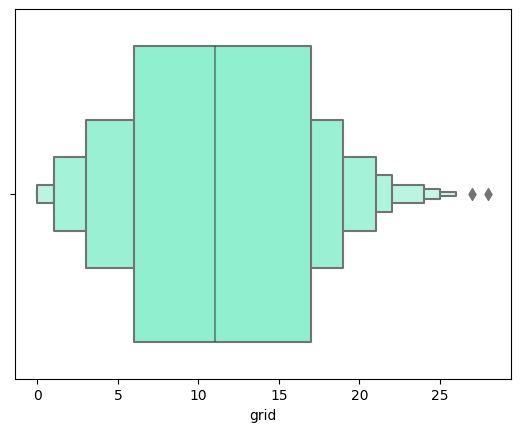

In [20]:
# Box plot for each variable - looking for outliers

print(sns.boxenplot(x=eda['grid'], color='aquamarine'))
print('Max Grid: ', eda.grid.max())

AxesSubplot(0.125,0.11;0.775x0.77)
Max Podium:  24


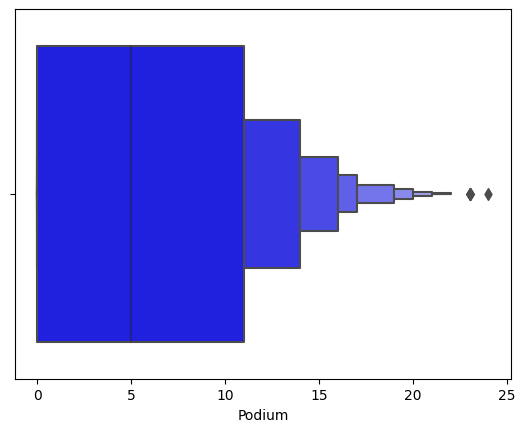

In [21]:
print(sns.boxenplot(x=eda['Podium'], color='blue'))
print('Max Podium: ', eda.Podium.max())

AxesSubplot(0.125,0.11;0.775x0.77)
Max altitude:  2227.0


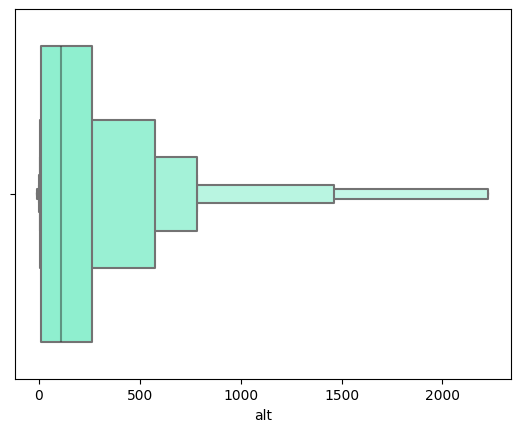

In [22]:
print(sns.boxenplot(x=eda['alt'], color='aquamarine'))
print('Max altitude: ', eda.alt.max())

AxesSubplot(0.125,0.11;0.775x0.77)
Max minutes:  245.72


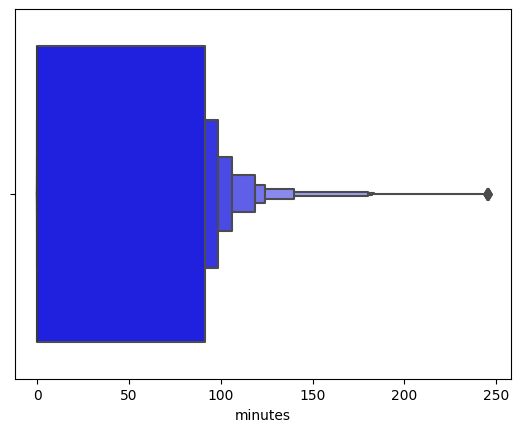

In [23]:
print(sns.boxenplot(x=eda['minutes'], color='blue'))
print('Max minutes: ', eda.minutes.max())


AxesSubplot(0.125,0.11;0.775x0.77)


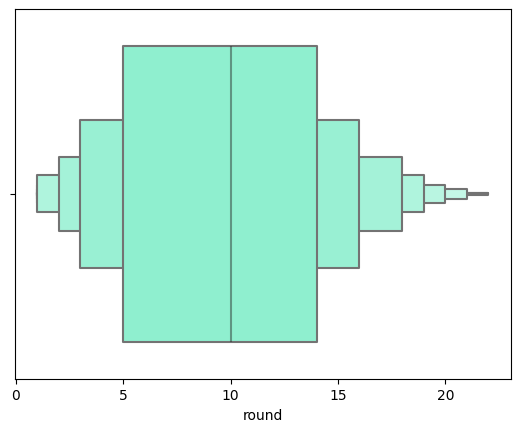

In [24]:
print(sns.boxenplot(x=eda['round'], color='aquamarine'))

AxesSubplot(0.125,0.11;0.775x0.77)
Max standing:  44


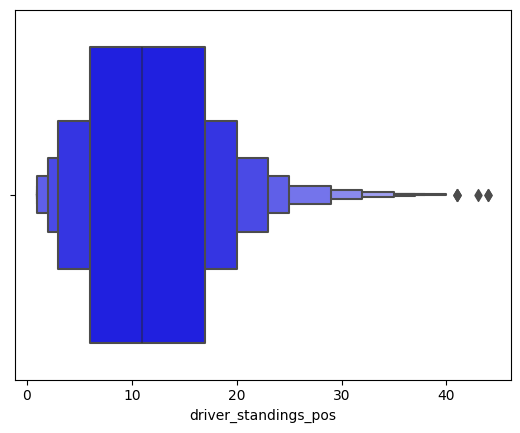

In [25]:
print(sns.boxenplot(x=eda['driver_standings_pos'], color='blue'))
print('Max standing: ', eda.driver_standings_pos.max())


AxesSubplot(0.125,0.11;0.775x0.77)
Max wins:  15


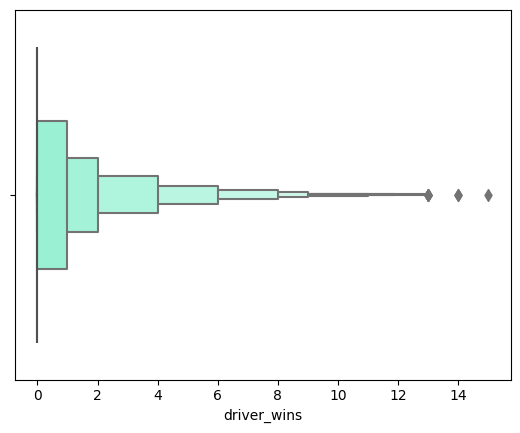

In [26]:
print(sns.boxenplot(x=eda['driver_wins'], color='aquamarine'))
print('Max wins: ', eda.driver_wins.max())

AxesSubplot(0.125,0.11;0.775x0.77)
Max points:  454.0


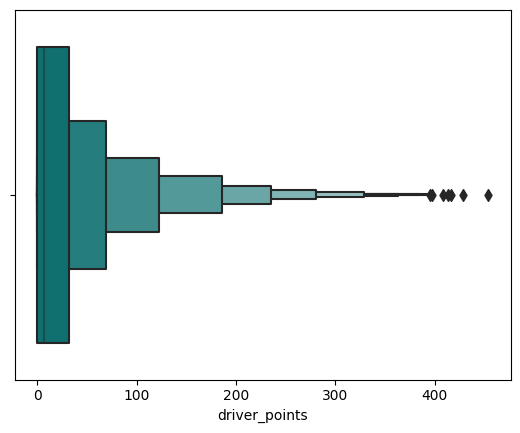

In [27]:
print(sns.boxenplot(x=eda['driver_points'], color='teal'))
print('Max points: ', eda.driver_points.max())

In [28]:
# Delete outliers
eda = eda[eda['grid'] <= 20]
eda = eda[eda['grid'] > 0]
eda = eda[eda['Podium'] <= 20]
eda = eda[eda['minutes'] <= 160]
eda = eda[eda['driver_standings_pos'] <= 40]
print(eda.shape)

(11104, 10)


<AxesSubplot:>

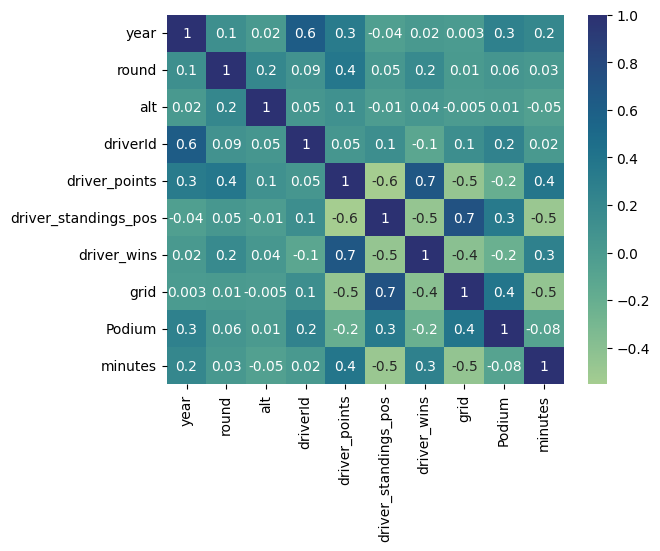

In [29]:
# Correlation heatmap
eda_corr = eda.corr()
sns.heatmap(eda_corr, cmap='crest', annot =True, fmt='.1g')

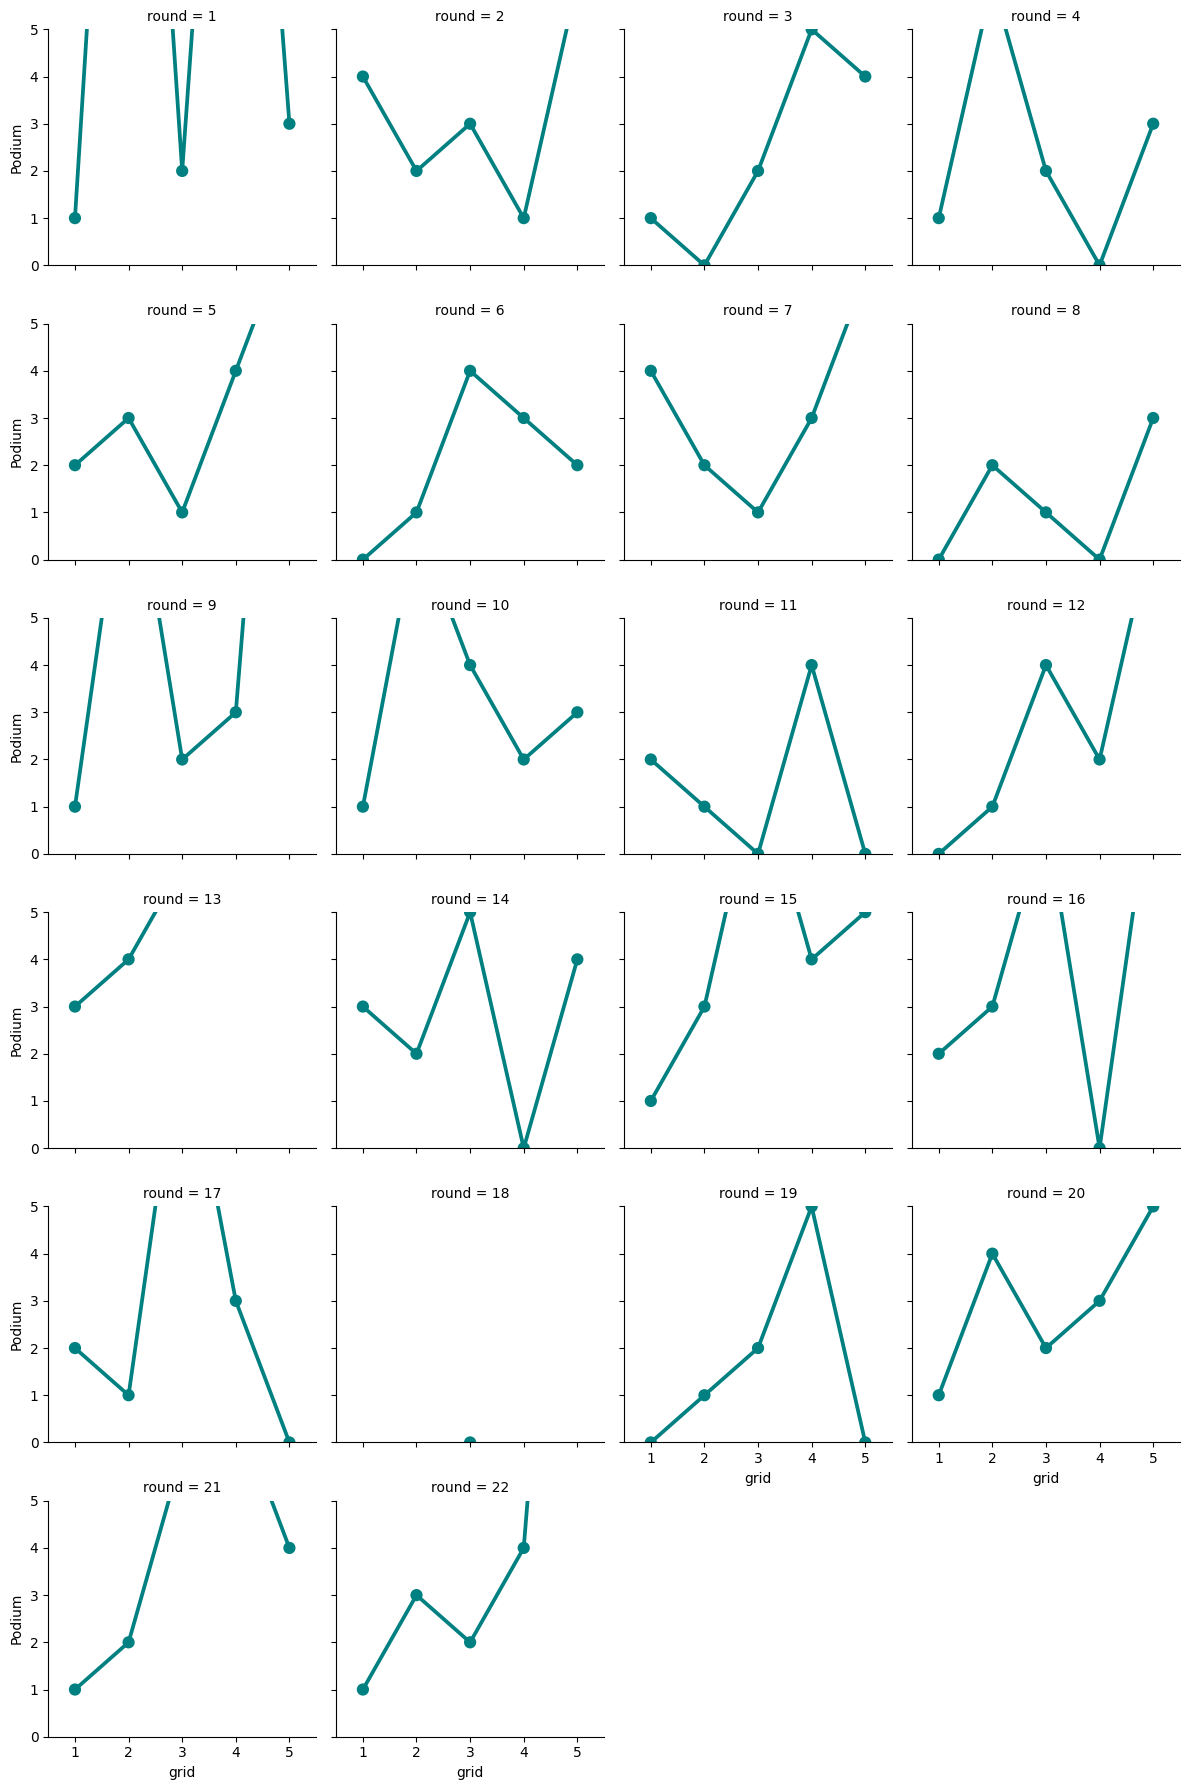

In [32]:
# Plotting each round from specified year to see 
# ** Want to Add driver as hue **

eda_year = eda[eda['year'] == 2022]
g = sns.FacetGrid(eda_year, col='round', col_wrap = 4, ylim=(0, 5))
g.map(sns.pointplot, "grid", "Podium", order=[1,2,3,4, 5], color='teal')


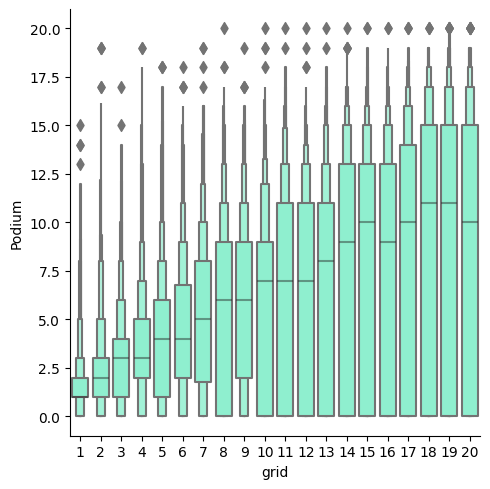

In [33]:
# Catplot to measure distribution between where you start on the grid and finish

sns.catplot(data=eda, x="grid", y="Podium", color='aquamarine', kind="boxen")

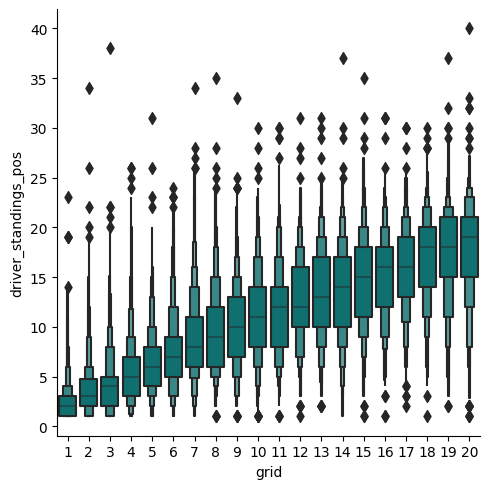

In [34]:
sns.catplot(data=eda, x="grid", y="driver_standings_pos", color='teal', kind="boxen")

## Train the Model

In [39]:
# Join data back with dummies

df = pd.merge(eda, data, on=['year', 'round', 'alt', 'driverId', 
                   'driver_points', 'driver_standings_pos', 'driver_wins', 
                   'grid', 'Podium', 'minutes'], how='left')
print(df.shape)


(11104, 110)


In [40]:
# Split the data

X = df.drop('Podium', axis=1) # features
y = df['Podium'] # target variable

# X_train & y_train are train_data and train_targets (in order)
# X_test & y_test are test_data and test_targets (in order)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8883, 109)
(2221, 109)
(8883,)
(2221,)


In [37]:
# # Scale the data
# scaler = StandardScaler()

# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
# X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

In [41]:
# Build the model
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) #* could try adam
    return model

In [42]:
# K-fold cross validation

k = 4
num_val_samples = len(X_train) // k
# num_epochs = 200
# all_scores = []
# for i in range(k):
#     print(f"Processing fold #{i}")
#     val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
#     val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
#     partial_train_data = np.concatenate(
#         [X_train[:i * num_val_samples],
#          X_train[(i + 1) * num_val_samples:]],
#         axis=0)
#     partial_train_targets = np.concatenate(
#         [y_train[:i * num_val_samples],
#          y_train[(i + 1) * num_val_samples:]],
#         axis=0)
#     model = build_model()
#     model.fit(partial_train_data, partial_train_targets,
#               epochs=num_epochs, batch_size=16, verbose=0)
#     val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
#     all_scores.append(val_mae)


# all_scores
# np.mean(all_scores)

# Saving the validation logs at each fold

num_epochs = 250
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_accuracy"]
    all_mae_histories.append(mae_history)


# Building the history of successive mean K-fold validation scores

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]



Processing fold #0
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  [y_train[:i * num_val_samples],
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:43: FutureWarning: The behavior of `series[i:

Processing fold #1


/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  [y_train[:i * num_val_samples],
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:43: FutureWarning: The behavior of `series[i:

Processing fold #2


/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  [y_train[:i * num_val_samples],
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:43: FutureWarning: The behavior of `series[i:

Processing fold #3


/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  [y_train[:i * num_val_samples],
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_22991/1865509010.py:43: FutureWarning: The behavior of `series[i:

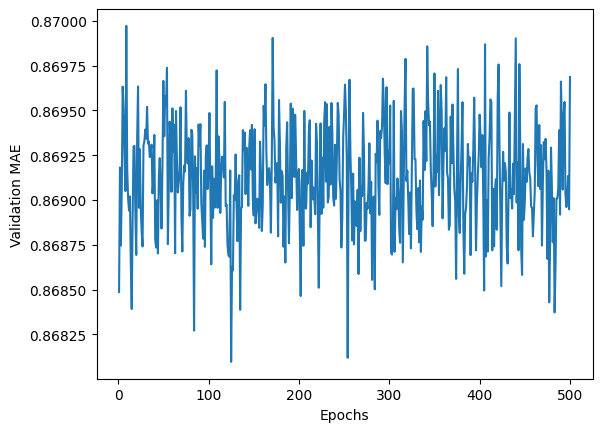

In [161]:
# Plotting validation scores

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

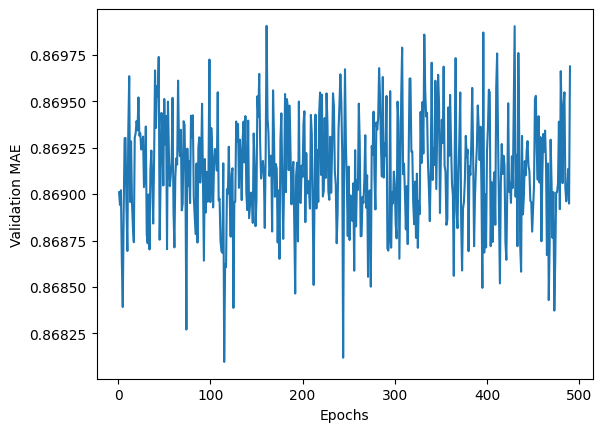

In [162]:
# Plotting validation scores, excluding the first 10 data points

truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show() 

In [52]:
# Training the final model

model = build_model()
model.fit(X_train, y_train,
          epochs=250, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

test_mae_score


2023-05-09 12:07:15.713160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/70 [========>.....................] - ETA: 0s - loss: 28.0961 - mae: 4.5906

2023-05-09 12:20:00.385134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 5ms/step - loss: 28.5303 - mae: 4.5910


4.591037750244141

In [53]:
# Generating predictions on new data


predictions = model.predict(X_test)
print(predictions[0])

70/70 [==============================] - 0s 2ms/step
[5.9969907]


2023-05-09 12:20:00.856777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [57]:
# Testing on known races from last year

df_2022 = X_test[X_test['year'] == 2022]
df_2022 = df_2022[df_2022['round'] == 11]
print(df_2022.head)

pred_year_round = model.predict(df_2022[:1])
print(pred_year_round)

# Predicts that Clarles LeClerc will get 6th -- he got 1st

<bound method NDFrame.head of        year  round    alt  driverId  driver_points  driver_standings_pos  \
10902  2022     11  678.0       844          170.0                     2   
10895  2022     11  678.0       832          133.0                     4   
10889  2022     11  678.0       817           17.0                    12   

       driver_wins  grid  minutes  constructor_ags  ...  circuit_shanghai  \
10902            3     2    84.41                0  ...                 0   
10895            1     3     0.00                0  ...                 0   
10889            0    11     0.00                0  ...                 0   

       circuit_silverstone  circuit_sochi  circuit_spa  circuit_suzuka  \
10902                    0              0            0               0   
10895                    0              0            0               0   
10889                    0              0            0               0   

       circuit_valencia  circuit_villeneuve  circuit_yas_ma